##  I. Introduction

Airbnb is a great platform that provides people online marketplace and service to arrange or offer lodging. As a travel enthusiast, Airbnb is always my first choice when I am planning a trip. Hosts need to provide details for their listed houses so that guests can use filters on the website to search for their preferred accomodations. For potential hosts, they must be very interested in how much they could earn from listing their houses on Airbnb. As far as I know, there is no such a model in public for predicting the yield of a new house on Airbnb. So, the object of this project is to apply machine learning models to help potential hosts gain some intuitions about the yield of their listed houses.

Fortunately, [Inside Airbnb](http://insideairbnb.com/get-the-data.html) has already aggregated all the publicly available informations from Airbnb site for public discussion. So, the dataset obtained from this website directly should be a good starting point for my machine learning model. In particular, I will the dataset collected in New York city compiled on 06 December, 2018. When selecting features for machine learning model, besides the variables provided in the datasets, the featured photo on the listing's website and the description of listing can be crucial for attracting more guests. So, I will analyze featured photos and text mining on the descriptions and add these two new features to improve the machine learning model. 

The project will be described as follows:
    1. Exploratory data analysis and data preprocessing.
    2. Feature engineering.
    3. Machine learning model.
    4. Model evaulation.


In [2]:
# load the dataset 
import pandas as pd

df = pd.read_csv('listings.csv')
print ('There are {} rows and {} columns in the dataset'.format(*df.shape))
df.head(3)

There are 49056 rows and 96 columns in the dataset


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (61,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2515,https://www.airbnb.com/rooms/2515,20181206022948,2018-12-06,Stay at Chez Chic budget room #1,Step into our artistic spacious apartment and ...,-PLEASE BOOK DIRECTLY. NO NEED TO SEND A REQUE...,Step into our artistic spacious apartment and ...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,1.42
1,21456,https://www.airbnb.com/rooms/21456,20181206022948,2018-12-06,Light-filled classic Central Park,"An adorable, classic, clean, light-filled one-...","An adorable, classic, clean, light-filled one-...","An adorable, classic, clean, light-filled one-...",none,"Diverse. Great coffee shops and restaurants, n...",...,f,NaN,NaN,f,f,moderate,t,t,1,0.72
2,2539,https://www.airbnb.com/rooms/2539,20181206022948,2018-12-06,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,NaN,NaN,f,f,moderate,f,f,8,0.25


In [3]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

## II. Exploratory data analysis and data preprocessing

### Data cleaning

There are 49056 observations and 96 columns in the dataset. However, not all the columns are needed for machine learning model. Especially, for a new house, there won't be any information about reviews. So columns containing informations about reviews should be dropped. These features are "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month". After carefully considering each features, these features are kept for further data analysis: 
> - **listing_url:** from the url, photos of the houses can be scraped. Needless to say, a comfortable featured photo of the apartment can attract more viewers and improve the yield.<br>
- **description:** description with more details about the apartment can help tourists to make the decision.<br>
- **latitude, longitude:** these two columns provide the information about the location. There are some other columns such as "transit", "zipcode", "street" are actually closely related to the location.<br>
- **property_type, room_type, bathrooms, bedrooms, bed_type, square_feet, amenities:** these columns describe the properties of the house, such as how large is the aparment, how many bathrooms or bedrooms it has.<br>
- **guests_included, cleaning_fee, extra_people, minimum_nights, maximum_nights, availability_365, cancellation_policy:** these columns provide informations about the policy of booking a room. The house with more flexible policy may be more prefered for some tourists who are not so sure about their schedules. <br>
- **reviews_per_month:** this column is kept because it will be used later for calculating the yield. <br>
- **scrape_id:** this id is kept for later image scraping.

The data cleaning process will be performed as follows:
1. Drop all the unnecessary columns.
2. "cleaning_fee","extra_people","price" have the dollar sign before the number. Need to remove the "\\$" and change the datetype from string to numerical values.
3. "property_type" has many categories, however, most of them only have few observations, so those categories can be combined into one category and name it "Other".
4. Handle missing values. First, columns including "bathrooms","bedrooms","cleaning_fee" and "reviews_per_month" have NULL values. They can be filled in with the median. There is also a column: "square_feet" whose majority of observations is missing, so this feature can be deleted. 
5. Check the distribution of variables. The distribution of "available_365" shows that some houses are only available for a few days within a year. Rooms that only available for a short time are not considered in this project. 

In [28]:
import os
import numpy as np
import re
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [6]:
# where to save figures and results
ROOT_DIR = os.path.dirname(os.path.realpath('__file__'))
Image_Path = os.path.join(ROOT_DIR,'Images')

if not os.path.exists('Images'):
    os.makedirs('Images')
Image_path = os.path.join('Images')

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(Image_path,fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Saving figure Distribution_of_variables
Dataset has 25194 rows and 20 columns.


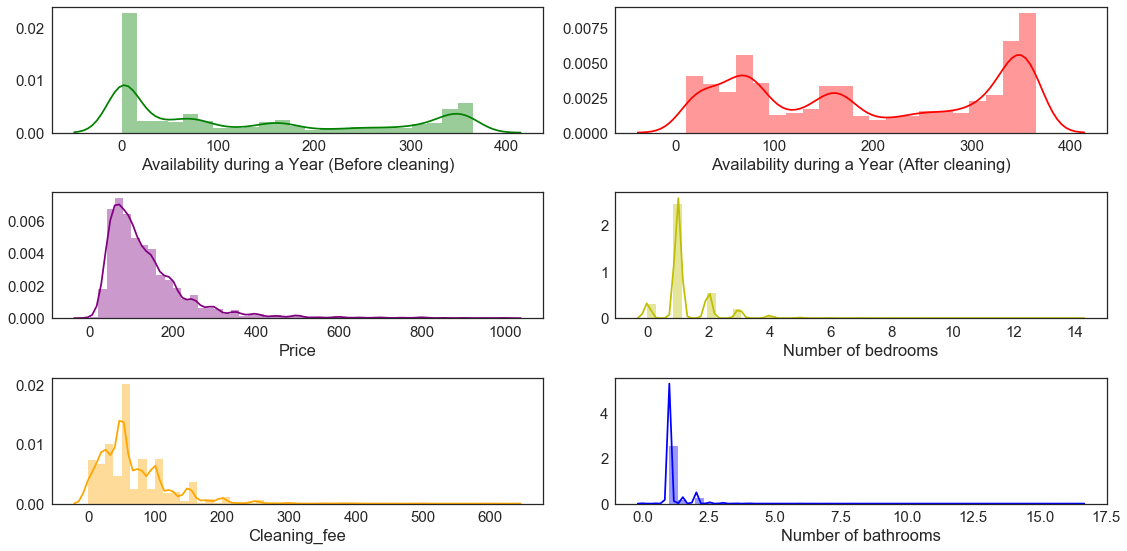

In [12]:
# drop all the unnecessary columns
feature_to_keep = ['listing_url','id','description','latitude','longitude','property_type','room_type','accommodates','bathrooms',
                  'bedrooms','bed_type','price','square_feet','guests_included','cleaning_fee','extra_people','minimum_nights',
                  'maximum_nights','availability_365','cancellation_policy','reviews_per_month']
new_df = df[feature_to_keep]

# remove the dollar sign before "cleaning_fee", "extra_people", "price" and change the datatype to numerical variables
feature_to_remove_dollar = ['cleaning_fee','extra_people','price']
new_df[feature_to_remove_dollar] = new_df[feature_to_remove_dollar].replace('\$','',regex = True)
new_df[feature_to_remove_dollar] = new_df[feature_to_remove_dollar].apply(pd.to_numeric,errors = "coerce")

# merge small catergories in property_type into one category "Other"
Other = ['Bed and breakfast','Resort','Boutique hotel','Guesthouse','Hostel','Hotel','Bungalow','Villa','Tiny house','Boat','Aparthotel',
         'Tent','Cottage','Camper/RV','Cabin','Casa particular (Cuba)','Nature lodge','Houseboat','Castle','Timeshare','Train','Cave','Bus',
         'Island','Earth house']
new_df['property_type'].loc[new_df['property_type'].isin(Other)] = "Other"

# drop the column "square_feet"
new_df = new_df.drop('square_feet', axis = 1)

# fill NaN with median value for 'bathrooms', 'bedrooms', 'cleaning_fee', 'price'
new_df['bathrooms'] = new_df['bathrooms'].fillna(new_df['bathrooms'].median())
new_df['bedrooms'] = new_df['bedrooms'].fillna(new_df['bedrooms'].median())
new_df['cleaning_fee'] = new_df['cleaning_fee'].fillna(new_df['cleaning_fee'].median())
new_df['price'] = new_df['price'].fillna(new_df['price'].median())

# there are 523 rows missing description, drop those rows
new_df = new_df.dropna()

# EDA of other variables and drop rows with availability_365 smaller than 10
%matplotlib inline
fig,axs = plt.subplots(ncols = 2, nrows = 3, figsize = (16,8))
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9,hspace=0.5,wspace=0.3)
sns.set(style = "white",font_scale=1.5)

sns.distplot(pd.Series(new_df['availability_365'],name = "Availability during a Year (Before cleaning)"), color ="g",ax = axs[0,0])
sns.distplot(pd.Series(new_df['price'], name = "Price"), color = "purple",ax = axs[1,0])

new_df = new_df[new_df['availability_365']>10]

sns.distplot(pd.Series(new_df['availability_365'],name = "Availability during a Year (After cleaning)"), color ="r",ax = axs[0,1])
sns.distplot(pd.Series(new_df['bedrooms'],name = "Number of bedrooms"),color = "y", ax = axs[1,1])
sns.distplot(pd.Series(new_df['bathrooms'],name = "Number of bathrooms"),color = 'blue', ax = axs[2,1])
sns.distplot(pd.Series(new_df['cleaning_fee'], name = "Cleaning_fee"), color = "orange",ax = axs[2,0])

save_fig("Distribution_of_variables")

print ("Dataset has {} rows and {} columns.".format(*new_df.shape))

After cleaning up the data, the new dataset now has 30372 rows and 21 columns without any missing values.

### Yield calculation

Inside Airbnb's ["San Francisco Model"](http://insideairbnb.com/about.html) will be used for yield calculation. The caculation is as follows:
> Yield $=$ Average length of stay $\times$ Price $\times$ Number of reviews $\times$ 12 Months $/$ Review_rate<br>

Here is how the website explained the model:<br>
> Inside Airbnb's __"San Francisco Model"__ uses as a modified methodology as follows:<br>
-  A __review rate of 50%__ is used to convert __reviews__ to __estimated bookings.__<br>
-  An __average length of stay__ is configured for each city, and this, multiplied by the __estimated bookings__ for each listings over a period gives the __occupancy rate__<br>
    - Where statements have been made about the average length of stay of Airbnb guests for a city, this was used.
    - For example, Airbnb reported 5.5 nights as the average length of stay for guests using Airbnb in San Francisco.
    - Where no public statements were made about average stays, a value of __3 nights per booking__ was used.
    - If a listing has a __higher minimum nights__ value than the average length of stay, the minimum nights value was used instead.
- The __occupancy rate__ was __capped at 70%__ - relatively high, but reasonable number for a highly occupied "hotel".
- __Number of nights__ booked or availble per year for the __high availability__ and __frequently rented__ metrics and filters were generally aligned with a city's short term rental laws designed to __protect residential housing.__<br>

In our case, the __Average length of stay__ will be 3 nights since there is no reported value. Also, if the minimum night is higher than 3 days, the average length of stay will be the value of minimum nights. 50% will be used as the review rate. The __Price__ in the model should be the sum of 'price' and 'cleaning_fee' in the dataset.

In [13]:
# calculate the Yield using San Francisco Model
review_rate = 0.5
new_df['average_length_of_stay'] = [3 if x < 3 else x for x in new_df['minimum_nights']]
new_df['yield'] = new_df['average_length_of_stay']*(new_df['price']+new_df['cleaning_fee'])*new_df['reviews_per_month']*12/review_rate

# reviews_per_month can be dropped now
new_df = new_df.drop('reviews_per_month',axis = 1)
new_df.head(3)

# save the current dataframe into a csv file
cleaned_listings = new_df.to_csv()

## III. Feature engineering

### Image analysis on featured photos

In most cases, hosts on Airbnb will upload some photos of their houses. These photos, especially the featured photo on the website, are extremely important to attract more viewers. An ideal photo should has desirable resolution and also be aesthetically attractive. Here I will use __[NIMA: Neural Image Assessment](https://ai.googleblog.com/2017/12/introducing-nima-neural-image-assessment.html)__ to score image quality. In NIMA, a deep convolutional neural network (CNN) is trained to predict whether the image will rated by a viewer as looking good (technically) and attractive (aesthetically). 

To assess both resolution and perceptual quality,  the model first initialize weights from object recognition networks, such as ImageNet, to understand general classification of objects. Then the perceptual quality assessment is achieved by fine-tuning on annotated data. This NIMA model gives a distribution of ratings for a given image on scale of 1 to 10 and also assign the probabilities. NIMA has been tested on Aesthetic Visual Analysis (AVA) datasets, and the rank given by NIMA matches closely the mean scores given by human raters.  

Here, I will use the pre-trained the NIMA model [Github](https://github.com/titu1994/neural-image-assessment) to predict the image score for each featured photo on the website and this score will be incorporated as a new feature for machine learning model. The workflow will be as follows:

1. Use beautiful soup to scrape images from the url link of the listed houses.
2. Predict the image score use NIMA model.



In [9]:
import requests
from bs4 import BeautifulSoup
import urllib.request
import scipy.misc

In [11]:
# extract the url for the feature photo from 'listings_url'
listings = new_df['listing_url']
image_link = {}
for file_url in listings:
    page = requests.get(file_url)    
    soup = BeautifulSoup(page.text,"html.parser")
    img_tags = soup.find_all('img')
    img_urls = [img['src'] for img in img_tags]
    for url in img_urls:
        if not url.startswith("https://a0.muscache.com/im/pictures/"):
            continue
        image_link[file_url] = url
        break

In [14]:
# add this featured photo url to the dataframe
new_df['image_link'] = new_df['listing_url'].map(image_link)

#some listings are no longer availble, so their image_link is missing.
new_df = new_df.dropna()

# set up the path for the photos output
ROOT_DIR = os.path.dirname(os.path.realpath('__file__'))
Photo_Path = os.path.join(ROOT_DIR,'Photos')

if not os.path.exists('Photos'):
    os.makedirs('Photos')
Photo_path = os.path.join('Photos')

# scraping images from the link
df_image = new_df[['id','image_link']].reset_index()

new_df = new_df.reset_index()

for i in range(len(df_image)):
   # link = df_image['image_link'][i]
    url_link = new_df['listing_url'][i]
   # print (url_link)
    link = image_link[url_link]
    photo_id = df_image['id'][i]
    image_name = os.path.join(Photo_Path,str(photo_id)+str('.jpg'))

    if not os.path.isfile(image_name):
        f = open(image_name,'wb')
        f.write(requests.get(link).content)
        f.close()

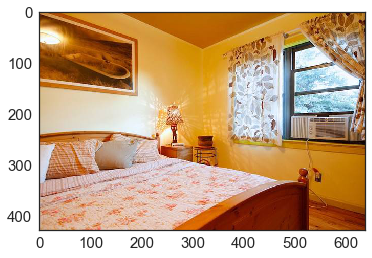

In [15]:
# take random samples
sample = df_image['image_link'][42]
photo_id = df_image['id'][42]
image_name = os.path.join(Photo_path, str(photo_id)+str('.jpg'))
img = scipy.misc.imread(image_name)
plt.imshow(img)       

In [30]:
# use NIMA model to score images
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from utils import mean_score, std_score

NIMA_dic = {}
image_name = os.path.join(Photo_path, str(photo_id)+str('.jpg'))

with tf.device('/CPU:0'):
    base_model = MobileNet((None, None, 3), alpha=1, include_top=False, pooling='avg', weights=None)
    x = Dropout(0.75)(base_model.output)
    x = Dense(10, activation='softmax')(x)

    model = Model(base_model.input, x)
    model.load_weights('weights/mobilenet_weights.h5')
        
    for i in range(len(df_image)):     
        photo_id = df_image['id'][i]
        image_name = os.path.join(Photo_path, str(photo_id)+str('.jpg'))

        img = load_img(image_name)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        scores = model.predict(x, batch_size=1, verbose=0)[0]

        mean = mean_score(scores)
        std = std_score(scores)
        NIMA_dic[photo_id] = mean
        #print("NIMA Score : %0.3f +- (%0.3f)" % (mean, std))

In [31]:
# add NIMA_score to new_df
new_df['NIMA_score'] = new_df['id'].map(NIMA_dic)

In [33]:
new_df.head(5)

,index,listing_url,id,description,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,cleaning_fee,extra_people,minimum_nights,maximum_nights,availability_365,cancellation_policy,average_length_of_stay,yield,image_link,NIMA_score
0,1,https://www.airbnb.com/rooms/21456,21456,"An adorable, classic, clean, light-filled one-...",40.797642,-73.961775,Apartment,Entire home/apt,2,1.0,...,40.0,28.0,5,365,248,moderate,5,15552.00,https://a0.muscache.com/im/pictures/111808/a94...,4.519021
1,2,https://www.airbnb.com/rooms/2539,2539,Renovated apt home in elevator building. Spaci...,40.647486,-73.972370,Apartment,Private room,4,1.0,...,25.0,25.0,1,730,365,moderate,3,3132.00,https://a0.muscache.com/im/pictures/3949d073-a...,5.003754
2,3,https://www.airbnb.com/rooms/2595,2595,"Find your romantic getaway to this beautiful, ...",40.753621,-73.983774,Apartment,Entire home/apt,2,1.0,...,100.0,0.0,1,1125,350,strict_14_with_grace_period,3,8658.00,https://a0.muscache.com/im/pictures/f028bdf9-e...,4.826283
3,4,https://www.airbnb.com/rooms/21644,21644,A great space in a beautiful neighborhood- min...,40.828028,-73.947308,Apartment,Private room,1,1.0,...,30.0,55.0,1,60,365,strict_14_with_grace_period,3,4369.68,https://a0.muscache.com/im/pictures/43197335/5...,4.466677
4,5,https://www.airbnb.com/rooms/3330,3330,"This is a spacious, clean, furnished master be...",40.708558,-73.942362,Apartment,Private room,2,1.0,...,125.0,50.0,5,730,216,strict_14_with_grace_period,5,8190.00,https://a0.muscache.com/im/pictures/41842659/5...,4.571960


### Sentiment analysis on 'description'

Description of the houses also has a great impact on guest's decision. An appropriate description can not only provide viewers with more details of the room but also leave them good impressions of the living environment using phrases such as "comfortable", "lovely bedroom", "bright and sunny room". So this part will focus on extraccting useful features from description. __Nature language processing (NLP)__ and __topic modeling__ will be carried out to analyze the text in 'description'. 

Topic model is a widely used text-mining tools to discover the abstract "topics" hidden in a collection of documents. Here, __Latent Dirichlet Allocation (LDA)__ will be used to discover topics in each description. In LDA model, a generative Bayesian inference model is used to assign each document with a probability distribution over topics, where topics are probability over words. 

Before topic modeling, the number of corpus in each description needs to be reduced. Non-english words, stop words and non-alphanumeric strings will be removed. The remaining corpus will also be lemmatised so that only important  and meaningful words will be kept later sentiment analysis. The corpus then needs to be converted into a __Document-term-matrix__, where each row corresponding to the documents and column corresponding to the terms. 


The pipeline of topic modeling on text of description will be as follows:
1. Tokenize words, remove non-english words, stop words and non-alphanumeric strings, convert all letters to lower case, and lemmatize words.
2. Convert the remaining corpus into Document Term Matrix.
3. Apply LDA model to model topics.
4. Use pyLDAvis.gensim to visualize topics.
5. Assign each observation with the topics with highest probability.


In [34]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.ldamodel import LdaModel

import json
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [35]:
def preprocess_text(corpus):
    processed_corpus = []
    english_words = set(nltk.corpus.words.words())
    english_stopwords = set(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[A-Za-z|!]+')
    for row in corpus:
        sentences = []
        word_tokens = tokenizer.tokenize(row)
        word_tokens_lower = [t.lower() for t in word_tokens]
        word_tokens_lower_english = [t for t in word_tokens_lower if t in english_words or not t.isalpha()]
        word_tokens_no_stops = [t for t in word_tokens_lower_english if not t in english_stopwords]
        word_tokens_no_stops_lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in word_tokens_no_stops]
        for word in word_tokens_no_stops_lemmatized:
            if len(word) > 2:
                sentences.append(word)
        processed_corpus.append(sentences)
    return processed_corpus

def pipline(processed_corpus):
    dictionary = Dictionary(processed_corpus)
    doc_term_matrix = [dictionary.doc2bow(listing) for listing in processed_corpus]
    return dictionary, doc_term_matrix

def lda_topic_model(doc_term_matrix,dictionary,num_topics = 3, passes = 2):
    LDA = LdaModel
    ldamodel = LDA(doc_term_matrix,num_topics = num_topics, id2word = dictionary, passes = passes)
    return ldamodel

def topic_feature(ldamodel,doc_term_matrix,df,new_col,num_topics):
    docTopicProbMat = ldamodel[doc_term_matrix]
    docTopicProbDf = pd.DataFrame(index = df.index, columns = range(0,num_topics))
    for i,doc in enumerate(docTopicProbMat):
        for topic in doc:
            docTopicProbDf.iloc[i,topic[0]] = topic[1]
    docTopicProbDf = docTopicProbDf.fillna(0)
    docTopicProbDf[new_col] = docTopicProbDf.idxmax(axis=1)
    df_topics = docTopicProbDf[new_col]
    df_new = pd.concat([df,df_topics],axis = 1)
    return df_new

In [36]:
corpus_description = new_df['description'].astype(str)

# use nlp package to process the text in description
processed_corpus_description = preprocess_text(corpus_description)

# generate the doc_term_matrix for lda model
dictionary_description, doc_term_matrix_description = pipline(processed_corpus_description)

# lda model for topic modeling
ldamodel_description = lda_topic_model(doc_term_matrix_description,dictionary_description)

# add the topic feature to the dataframe
final_df = topic_feature(ldamodel_description,doc_term_matrix_description,new_df,new_col = 'description_topic', num_topics =3)

# visualization of the lda model and save it as html page
p_description = pyLDAvis.gensim.prepare(ldamodel_description, doc_term_matrix_description, dictionary_description)
pyLDAvis.save_html(p_description,'lda_description.html')
p_description

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      34.922226        1       1 -0.008218 -0.092251
0      33.256050        1       2 -0.093856  0.051930
2      31.821728        1       3  0.102075  0.040322, topic_info=     Category          Freq       Term         Total  loglift  logprob
term                                                                  
72    Default  10722.000000      train  10722.000000  30.0000  30.0000
44    Default  28305.000000       room  28305.000000  29.0000  29.0000
135   Default  11397.000000       away  11397.000000  28.0000  28.0000
69    Default   9902.000000       park   9902.000000  27.0000  27.0000
52    Default  11609.000000       walk  11609.000000  26.0000  26.0000
488   Default   5693.000000        min   5693.000000  25.0000  25.0000
368   Default   9669.000000     subway   9669.000000  24.0000  24.0000
53    Default   5436.000000    walking   5436.000000  23.0000  23.0000
345   Default   4595.000000     please   4595.000000  22.0000  22.0000
4     Default  14352.000000        bed  14352.000000  21.0000  21.0000
62    Default   3591.000000        bus   3591.000000  20.0000  20.0000
770   Default   4666.000000     minute   4666.000000  19.0000  19.0000
18    Default   4530.000000   distance   4530.000000  18.0000  18.0000
105   Default   7497.000000      large   7497.000000  17.0000  17.0000
41    Default   6973.000000      queen   6973.000000  16.0000  16.0000
64    Default   7409.000000      close   7409.000000  15.0000  15.0000
474   Default   4732.000000    station   4732.000000  14.0000  14.0000
103   Default   4698.000000       high   4698.000000  13.0000  13.0000
6     Default   5642.000000      block   5642.000000  12.0000  12.0000
330   Default   4458.000000        use   4458.000000  11.0000  11.0000
163   Default   3070.000000       sofa   3070.000000  10.0000  10.0000
110   Default   3958.000000     modern   3958.000000   9.0000   9.0000
47    Default   7090.000000       size   7090.000000   8.0000   8.0000
335   Default   5106.000000      fully   5106.000000   7.0000   7.0000
8     Default   5893.000000    central   5893.000000   6.0000   6.0000
253   Default   8431.000000     street   8431.000000   5.0000   5.0000
239   Default   2351.000000       loft   2351.000000   4.0000   4.0000
146   Default   4637.000000      guest   4637.000000   3.0000   3.0000
589   Default   6842.000000      place   6842.000000   2.0000   2.0000
26    Default  10792.000000       full  10792.000000   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
627    Topic3   1896.323242      brand   2602.301270   0.8285  -5.4697
539    Topic3   1022.799316       oven   1266.570190   0.9313  -6.0870
625    Topic3   1699.597168     washer   2319.497314   0.8341  -5.5792
885    Topic3   1636.939087       unit   2257.702637   0.8235  -5.6167
4      Topic3   7418.728027        bed  14352.841797   0.4851  -4.1056
47     Topic3   4026.444092       size   7090.324219   0.5792  -4.7167
61     Topic3   4871.244629   building   9060.818359   0.5244  -4.5262
26     Topic3   5570.354980       full  10792.361328   0.4836  -4.3921
5      Topic3   8544.608398    bedroom  18732.261719   0.3601  -3.9643
1      Topic3  11995.432617  apartment  30954.859375   0.1970  -3.6251
151    Topic3   5664.839844        new  12073.905273   0.3883  -4.3753
534    Topic3   2501.336182     dining   4031.940918   0.6676  -5.1928
24     Topic3   4312.537109      floor   8462.575195   0.4709  -4.6481
31     Topic3   7372.365234    kitchen  19559.476562   0.1693  -4.1118
541    Topic3   1860.073853      table   2759.417969   0.7506  -5.4890
149    Topic3   5497.965332     living  13542.403320   0.2436  -4.4052
98     Topic3   1912.665649  furnished   2916.717773   0.7231  -5.4611
71     Topic3   2766.180176   spacious   5700.879883   0.4219  -5.0921
37     Topic3   3713.686279        one  10843.396484   0.0735  -4.

pyLDAvis package is a great package to visualize the LDA model. The area of the circles means the prevalence of each topic. Here I chose the cluster the corpus into three topics. The red bar represents the estimated term frequency within selected topic and the blue bar represents the overall term frequency. In topic 1, the prevalent term is about layout of the room, for example, there are words "kitchen", "bathroom", "bedroom". Topic 2 is about the living environment because it has words "new","private","space","large". Topic 3 is correlated with location or transit with words "subway", "walk","away". There are some overlaps among these three topics, which can be improved to better serve the machine learninng model. At this moment, I will go ahead with the current model.


## IV. Machine learning model

In this part, 3 regression algorithms: __linear regression, decision tree__ and __random forest__ will be trained to predict the yield. Linear regression is the simplest algorithm and will be used as the baseline model. Decision tree model can capture the nonlinear relationships in the dataset while random forest is a more complex model and able to provide higher accuracy. 

To measure the accuracy of the model, MSE (mean squared error) is used as evaluation metrics. The target for prediction is "yield". "price" and "reviews_per_month", "average_length_of_stay" have strong correlation with "yield" because they are used for yield calculation. Catergorical features also need to be converted to numerical features so that they can be fed into machine learning algorithms. To split the whole dataset into a training set and a testing set, the dataset will be randomly shuffled first and 25% will be used as the splitting ratio.

Once the 3 algorithms have been applied and trained, they will be compared based on MSE value. The smaller MSE, the better accuracy. The best algorithm will be chosen and the model will be further fine-tuned using GridSearchCV function in scikit-learn. The to-do list in this part is:

1. Clean-up the dataset: separate the "yield" from the dataset and save it as the target, drop "price", "average_length_of_stay" and "reviews_per_month", convert catergorical variables into numerical features. Other columns including "level_0", "id", "listing_url", "description","image_link" can be dropped as well since they are not needed any more.
2. Randomly shuffle the dataset to remove inherent order and split the dataset into a training set and a test set using 75:25 ratio.
3. Use linear regression, decision tree, and random forest separately to train the model and calculate the MSE value.
4. Select the model with lowest MSE value for further refinement.


In [38]:
# drop unnecessary columns
cols_to_drop = ['price','average_length_of_stay','minimum_nights','cleaning_fee','index', 'id','listing_url','description','image_link']
final_df = final_df.drop(cols_to_drop, axis = 1)

# convert strings to numerical features
categorical_feats = ['property_type', 'room_type', 'bed_type', 'cancellation_policy','description_topic' ]
final_df = pd.get_dummies(final_df, columns = categorical_feats, drop_first = False)

# separate the target variable "yield" from the dataset
target = final_df['yield']
final_df = final_df.drop(['yield'], axis = 1)

print ("Final dataset has {} rows, {} columns.".format(*final_df.shape))

Final dataset has 21770 rows, 35 columns.


In [23]:
final_df.head(5)

,index,listing_url,id,description,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,extra_people,minimum_nights,maximum_nights,availability_365,cancellation_policy,average_length_of_stay,yield,image_link,NIMA_score,description_topic
0,1,https://www.airbnb.com/rooms/21456,21456,"An adorable, classic, clean, light-filled one-...",40.797642,-73.961775,Apartment,Entire home/apt,2,1.0,...,28.0,5,365,248,moderate,5,15552.00,https://a0.muscache.com/im/pictures/111808/a94...,NaN,2
1,2,https://www.airbnb.com/rooms/2539,2539,Renovated apt home in elevator building. Spaci...,40.647486,-73.972370,Apartment,Private room,4,1.0,...,25.0,1,730,365,moderate,3,3132.00,https://a0.muscache.com/im/pictures/3949d073-a...,NaN,0
2,3,https://www.airbnb.com/rooms/2595,2595,"Find your romantic getaway to this beautiful, ...",40.753621,-73.983774,Apartment,Entire home/apt,2,1.0,...,0.0,1,1125,350,strict_14_with_grace_period,3,8658.00,https://a0.muscache.com/im/pictures/f028bdf9-e...,NaN,2
3,4,https://www.airbnb.com/rooms/21644,21644,A great space in a beautiful neighborhood- min...,40.828028,-73.947308,Apartment,Private room,1,1.0,...,55.0,1,60,365,strict_14_with_grace_period,3,4369.68,https://a0.muscache.com/im/pictures/43197335/5...,NaN,1
4,5,https://www.airbnb.com/rooms/3330,3330,"This is a spacious, clean, furnished master be...",40.708558,-73.942362,Apartment,Private room,2,1.0,...,50.0,5,730,216,strict_14_with_grace_period,5,8190.00,https://a0.muscache.com/im/pictures/41842659/5...,NaN,1


In [39]:
# split the training set and testing set
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
seed = 42
X_train,X_test,y_train,y_test = train_test_split(final_df,target,random_state=seed)

In [40]:
final_df.to_csv('final_df.csv')

### Linear regression 

In [41]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

print("Mean squared error: %.3f" %mean_squared_error(y_test,y_pred_linreg))
print("Variance score: %.3f" %r2_score(y_test,y_pred_linreg))

Mean squared error: 4781289307.734
Variance score: 0.104


### Decision trees

In [42]:
from sklearn.tree import DecisionTreeRegressor
for K in [1,3,5,7,10,15,20,30]:
    dt_reg = DecisionTreeRegressor(random_state = seed, max_depth = K).fit(X_train,y_train)
    y_dt_pred = dt_reg.predict(X_test)
    print ("max_depth = " + str(K))
    print ("Mean squared error: %.3f" %mean_squared_error(y_test,y_dt_pred))
    print ("Variance score: %.3f" %r2_score(y_test,y_dt_pred))

max_depth = 1
Mean squared error: 5024803151.882
Variance score: 0.059
max_depth = 3
Mean squared error: 4789684788.300
Variance score: 0.103
max_depth = 5
Mean squared error: 4588601834.546
Variance score: 0.140
max_depth = 7
Mean squared error: 4941400033.278
Variance score: 0.074
max_depth = 10
Mean squared error: 7397470407.079
Variance score: -0.386
max_depth = 15
Mean squared error: 8291334303.409
Variance score: -0.553
max_depth = 20
Mean squared error: 8903546780.280
Variance score: -0.668
max_depth = 30
Mean squared error: 9127202991.476
Variance score: -0.710


### Random forest

In [43]:
from sklearn.ensemble import RandomForestRegressor

for K in [1,3,5,7,10,15,20]:
    rf_reg = RandomForestRegressor(random_state = seed, bootstrap = True, criterion = 'mse', max_depth = K,
                                   max_features = 'auto', min_samples_split = 5, n_estimators = 150).fit(X_train, y_train)
    y_rf_pred = rf_reg.predict(X_test)

    print ("Max_depth = " + str(K))
    print("Mean squared error: %.3f" %mean_squared_error(y_test,y_rf_pred))
    print("Variance score: %.3f" %r2_score(y_test,y_rf_pred))

Max_depth = 1
Mean squared error: 4933940765.512
Variance score: 0.076
Max_depth = 3
Mean squared error: 4792797066.583
Variance score: 0.102
Max_depth = 5
Mean squared error: 4714308643.520
Variance score: 0.117
Max_depth = 7
Mean squared error: 4708215874.375
Variance score: 0.118
Max_depth = 10
Mean squared error: 4678417980.839
Variance score: 0.124
Max_depth = 15
Mean squared error: 4653522451.420
Variance score: 0.128
Max_depth = 20
Mean squared error: 4671374608.185
Variance score: 0.125


##  V. Fine tuning and model evaluation

As expected, random forest gave the lowest MSE and highest variance score. So this part will focusing on fine tuning the model and test how robust the model is. It  will be structured into three parts:

1. Using GridSearchCV to fine tuning the model using random forest regressor.
2. Check the importance of each feature in the dataset, especially the two features from image analysis and text mining.
3. Test the robustness of the model by using a different seed.

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators" :[150,175,200,225,250,300],
             "criterion": ['mse'],
             "max_features": ['auto'],
             "max_depth": [3,5,7,9,11,15,20],
             "min_samples_split":[4,6,8,10,12],
             "bootstrap":[True]}

rf_fine = RandomForestRegressor(random_state = seed)
rf_cv = GridSearchCV(rf_fine,param_grid,cv=5).fit(X_train,y_train)
y_rf_cv_pred = rf_cv.predict(X_test)
print("Mean squared error: %.3f" % mean_squared_error(y_test, y_rf_cv_pred))
print('Variance score: %.3f' % r2_score(y_test, y_rf_cv_pred))
print("Best Parameters: {}".format(rf_cv.best_params_))

Mean squared error: 4637113425.384
Variance score: 0.131
Best Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 12, 'n_estimators': 300}


In [45]:
rf_final = rf_cv.best_estimator_
feature_import = rf_final.feature_importances_*100
feature_import = pd.DataFrame(list(zip(feature_import,X_train.columns.values)))
feature_import = feature_import.sort_values(by=0,axis=0,ascending=False)
feature_import.columns = ['importance %','feature']
print(feature_import[:20])

    importance %                                          feature
1      18.040199                                        longitude
0      17.378363                                         latitude
2      12.976208                                     accommodates
8      10.915914                                 availability_365
9       8.753188                                       NIMA_score
18      6.882709                        room_type_Entire home/apt
7       5.939127                                   maximum_nights
4       4.540373                                         bedrooms
5       3.179635                                  guests_included
6       3.088270                                     extra_people
3       2.322952                                        bathrooms
13      1.532435                              property_type_House
34      0.658664                              description_topic_2
14      0.462011                               property_type_Loft
11      0.

Location has a combined importance of 36% - 18.4% from longitude and 17.5% from latitude, which make sense to me. A convenient location can be very attractive for viewers. Other features such as "accommodates" and "availability_365" also occupied 13.5% and 11.1% importance. Interestingly, the __NIMA score__ engineered from photos on the website have __9.3%__ of importance. The other feature __"description_topic"__ also has combined __>1%__ of importance (sum of "description_topic_2" and "description_topic_0"). This information shows that there are valuable information in the photo and description text.

To test the robustness of the model, random_state for shuffling dataset will be changed, the ratio of training set and test set will also be changed to 0.3. 

In [46]:
random_state = 35
X_train,X_test,y_train,y_test = train_test_split(final_df,target,test_size = 0.3,random_state=seed)

In [47]:
# Fit and make prediction
rf_final.fit(X_train, y_train)
rf_y_pred = rf_final.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, rf_y_pred))

Mean squared error: 4209814319.47
Variance score: 0.14


There is no significant difference after adjusting the random state and proportions of training set and test set, which demonstrate that the final model is robust.

## VI. Conclusion and reflection

The original goal of this project is to apply machine learning algorithms to give potential hosts some insights on how much they can earn from listing their beloved houses on Airbnb. The information from Inside Airbnb is definitely very helpful. Combined my own experience of browsing accommodations in Airbnb, I added two additional features: image score and topic modeling from web photos and descriptions. It turned out that these two features actually contain valuable informations. Of couse, my solution is not perfect, here are two points I would like to spend more time on further improving my model.

1. There are some overlaps among the three topics, so potential improvement would be implement the topic modeling methods. It would be worthwhile comparing LDA with other algorithms, such as Non-negative matrix factorization.

2. Should I consider time effect? If a host gets very positive reviews from first few guests, it's possible that new viewers will also consider choosing their houses. How should I predict time series?

Having spent lots of time on data in chemistry as a chemistry PhD candidate, I always want to know the data in real world and what we can learn from it. I had a great time when doing this project. From designing the workflow, analyzing images to text mining, I learnt a lot and am very pleased to see that my model has suggested some informations from images and text on the website. In the end, I would also like to learn how to design a web application where hosts can actually upload their photos and informations about their houses and get an estimation of their yield using the model.
